<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/validate_desi_complexdust_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/speculator_fork

/content/drive/My Drive/speculator_fork


In [3]:
import os 
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from speculator import SpectrumPCA
from speculator import Speculator

In [4]:
n_param = 10
n_pcas  = [50, 30, 30]

In [5]:
# read DESI wavelength
wave = np.load('wave_fsps.npy')

wave_bins = [(wave < 4500), (wave >= 4500) & (wave < 6500), (wave >= 6500)]

In [6]:
PCABases = [] 
for i in range(len(n_pcas)): 
  # load trained PCA basis object
  PCABasis = SpectrumPCA(
          n_parameters=n_param,       # number of parameters
          n_wavelengths=np.sum(wave_bins[i]),       # number of wavelength values
          n_pcas=n_pcas[i],              # number of pca coefficients to include in the basis 
          spectrum_filenames=None,  # list of filenames containing the (un-normalized) log spectra for training the PCA
          parameter_filenames=[], # list of filenames containing the corresponding parameter values
          parameter_selection=None) # pass an optional function that takes in parameter vector(s) and returns True/False for any extra parameter cuts we want to impose on the training sample (eg we may want to restrict the parameter ranges)
  PCABasis._load_from_file('DESI_complexdust.0_499.seed0.wave_bin%i.pca%i.hdf5' % (i, n_pcas[i]))
  PCABases.append(PCABasis)

In [7]:
# read in training parameters and data
theta_test = np.load('DESI_complexdust.theta_test.npy')
_logspectrum_test = np.load('DESI_complexdust.logspectrum_fsps_test.npy')
logspectrum_test = []
for wave_bin in wave_bins: 
  logspectrum_test.append(_logspectrum_test[:,wave_bin])

In [8]:
# validate pca
spectra_in_bases = []
for i in range(len(wave_bins)): 
  _spec = logspectrum_test[i]
  normalized_spec = (_spec - PCABases[i].spectrum_shift) / PCABases[i].spectrum_scale

  # transform to PCA basis and back
  spectra_pca = np.dot(normalized_spec, PCABases[i].pca_transform_matrix.T)
  spectra_in_basis = np.dot(spectra_pca, PCABases[i].pca_transform_matrix)*PCABases[i].spectrum_scale + PCABases[i].spectrum_shift
  spectra_in_bases.append(spectra_in_basis)

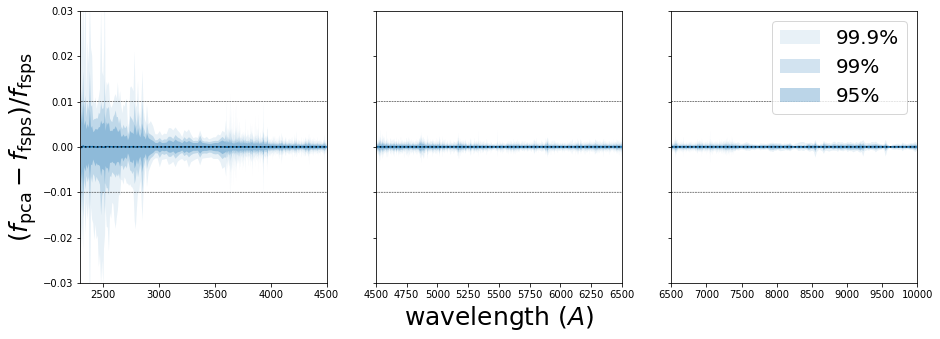

In [9]:
fig = plt.figure(figsize=(15,5))
for iwave in range(len(wave_bins)): 
  # more quantitative accuracy test of the Speculator model 
  frac_dspectrum = (10**spectra_in_bases[iwave] - 10**logspectrum_test[iwave]) / 10**logspectrum_test[iwave]
  frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, 
        [0.0005, 0.005, 0.025, 0.5, 0.975, 0.995, 0.9995], axis=0)

  sub = fig.add_subplot(1,3,iwave+1)
  sub.fill_between(wave[wave_bins[iwave]], frac_dspectrum_quantiles[0],
          frac_dspectrum_quantiles[6], fc='C0', ec='none', alpha=0.1, label='99.9%')
  sub.fill_between(wave[wave_bins[iwave]], frac_dspectrum_quantiles[1],
          frac_dspectrum_quantiles[5], fc='C0', ec='none', alpha=0.2, label='99%')
  sub.fill_between(wave[wave_bins[iwave]], frac_dspectrum_quantiles[2],
          frac_dspectrum_quantiles[4], fc='C0', ec='none', alpha=0.3, label='95%')
  sub.plot(wave[wave_bins[iwave]], frac_dspectrum_quantiles[3], c='C0', ls='-') 
  sub.plot(wave, np.zeros(len(wave)), c='k', ls=':') 
  sub.plot(wave, 0.01 * np.ones(len(wave)), c='k', ls='--', lw=0.5)
  sub.plot(wave, -0.01 * np.ones(len(wave)), c='k', ls='--', lw=0.5)
  if iwave == len(wave_bins) - 1: sub.legend(loc='upper right', fontsize=20)
  if iwave == 0: sub.set_xlim(2.3e3, 4.5e3)
  elif iwave == 1: 
    sub.set_xlabel('wavelength ($A$)', fontsize=25) 
    sub.set_xlim(4.5e3, 6.5e3)
  elif iwave == 2: sub.set_xlim(6.5e3, 1e4)
  if iwave == 0: sub.set_ylabel(r'$(f_{\rm pca} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
  sub.set_ylim(-0.03, 0.03) 
  if iwave != 0 : sub.set_yticklabels([])